# Progetto CPS COVID-2


---

**Authors:** ***Giuseppe Lasco & Marco Marcucci***

**Group Name:** ***Carbonara&Firricidd***


---
Lo scopo del progetto consiste nel rielaborare il dataset ***"time_series_covid19_confirmed_global.csv"***,
 in modo da trasformarlo in uno più utile al nostro scopo, per poi confrontare, attraverso l'utilizzo di più grafici,
 l'andamento dei nuovi casi giornalieri di persone affette da covid-19, globalmente e non.

Di seguito l'import delle librerie utilizzate:

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as md

print("Pandas version: ", pd.__version__)
print("Matplotlib version: ", matplotlib.__version__)
print("Numpy version: ", np.__version__)

Pandas version:  1.1.3
Matplotlib version:  3.3.1
Numpy version:  1.19.1


Il primo passo consiste nel reperire il dataset ***"time_series_covid19_confirmed_global.csv"*** da GitHub.

In [2]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/" \
      "time_series_covid19_confirmed_global.csv"

df_raw = pd.read_csv(URL)

La funzione ***preprocessing()*** permette di manipolare il dataset recuperato trasformandolo nel dataset richiesto.
Se viene settato a ***True*** il parametro ***world***, viene costruito il dataset cumulativo mondiale, anziché per
paese.

In [3]:
def preprocessing(df, world):
    """

    :param df: dataframe grezzo
    :param world: flag booleano
    :return: dataframe rielaborato
    """
    count = 0 # contatore per paesi con più stati
    df_final = pd.DataFrame(columns=["Country", "Date", "Confirmed", "New Confirmed"])
    for country in df.iterrows(): # iterazione sulle righe
        if not world:
            if count != 0: # entra se il paese ha più di uno stato
                count = count - 1 # decremento di uno per ogni stato del paese considerato
                continue
            country_name = country[1].get('Country/Region')
            df_country = df[df['Country/Region'] == country_name] # slicing del dataset sul paese considerato
        else:
            df_country = df # nel caso world viene considerato l'intero dataset
            country_name = "World"
        count = df_country.shape[0] - 1 # set del count al numero di stati del paese meno uno
        df_country = df_country.iloc[:, 4:].sum(axis=0) # somma dei confirmed sugli stati per ogni giorno
        # di un country (somma per righe), risultato in una Series con index le date
        df_country = pd.Series.to_frame(df_country)
        df_country = df_country[0].reset_index() # inserimento indice numerico invece della data
        df_country.columns = ["Date", "Confirmed"]
        df_country['Date'] = pd.to_datetime(df_country['Date'], infer_datetime_format=True)
        df_country['Date'] = df_country['Date'].dt.strftime('%Y/%m/%d') # conversione date
        df_country.insert(loc=0, column="Country",
                          value=[country_name] * df_country.shape[0]) # inserimento colonna country
        new_confirmed_list = [np.NaN] # calcolo dei new confirmed, considerando NaN il primo incremeto
        for i in range(0, df_country.shape[0] - 1):
            # iterando sui giorni, viene calcolato l'incremento giornaliero
            new_confirmed_list.append(df_country["Confirmed"][i+1] - df_country["Confirmed"][i])
        df_country.insert(df_country.shape[1],
                          column="New Confirmed", value=new_confirmed_list) # inserimento colonna new confirmed
        df_final = df_final.append(df_country, ignore_index=True) # costruzione step by step del dataset finale
        if world: # nel caso world basta una iterazione
            break
    return df_final

df = preprocessing(df_raw, False)
df_world = preprocessing(df_raw, True)

Di seguito un summary del dataset richiesto:

In [4]:
df

Country        Date Confirmed  New Confirmed
0      Afghanistan  2020/01/22         0            NaN
1      Afghanistan  2020/01/23         0            0.0
2      Afghanistan  2020/01/24         0            0.0
3      Afghanistan  2020/01/25         0            0.0
4      Afghanistan  2020/01/26         0            0.0
...            ...         ...       ...            ...
70651     Zimbabwe  2021/01/19     28675          783.0
70652     Zimbabwe  2021/01/20     29408          733.0
70653     Zimbabwe  2021/01/21     30047          639.0
70654     Zimbabwe  2021/01/22     30523          476.0
70655     Zimbabwe  2021/01/23     31007          484.0

[70656 rows x 4 columns]

Di seguito un summary del dataset cumulativo mondiale:

In [5]:
df_world

Country        Date Confirmed  New Confirmed
0     World  2020/01/22       557            NaN
1     World  2020/01/23       655           98.0
2     World  2020/01/24       941          286.0
3     World  2020/01/25      1433          492.0
4     World  2020/01/26      2118          685.0
..      ...         ...       ...            ...
363   World  2021/01/19  96167933       608286.0
364   World  2021/01/20  96862056       694123.0
365   World  2021/01/21  97518881       656825.0
366   World  2021/01/22  98177108       658227.0
367   World  2021/01/23  98746982       569874.0

[368 rows x 4 columns]

La seguente funzione permette di graficare l'andamento dei ***"New Confirmed"*** di un daterminato paese.

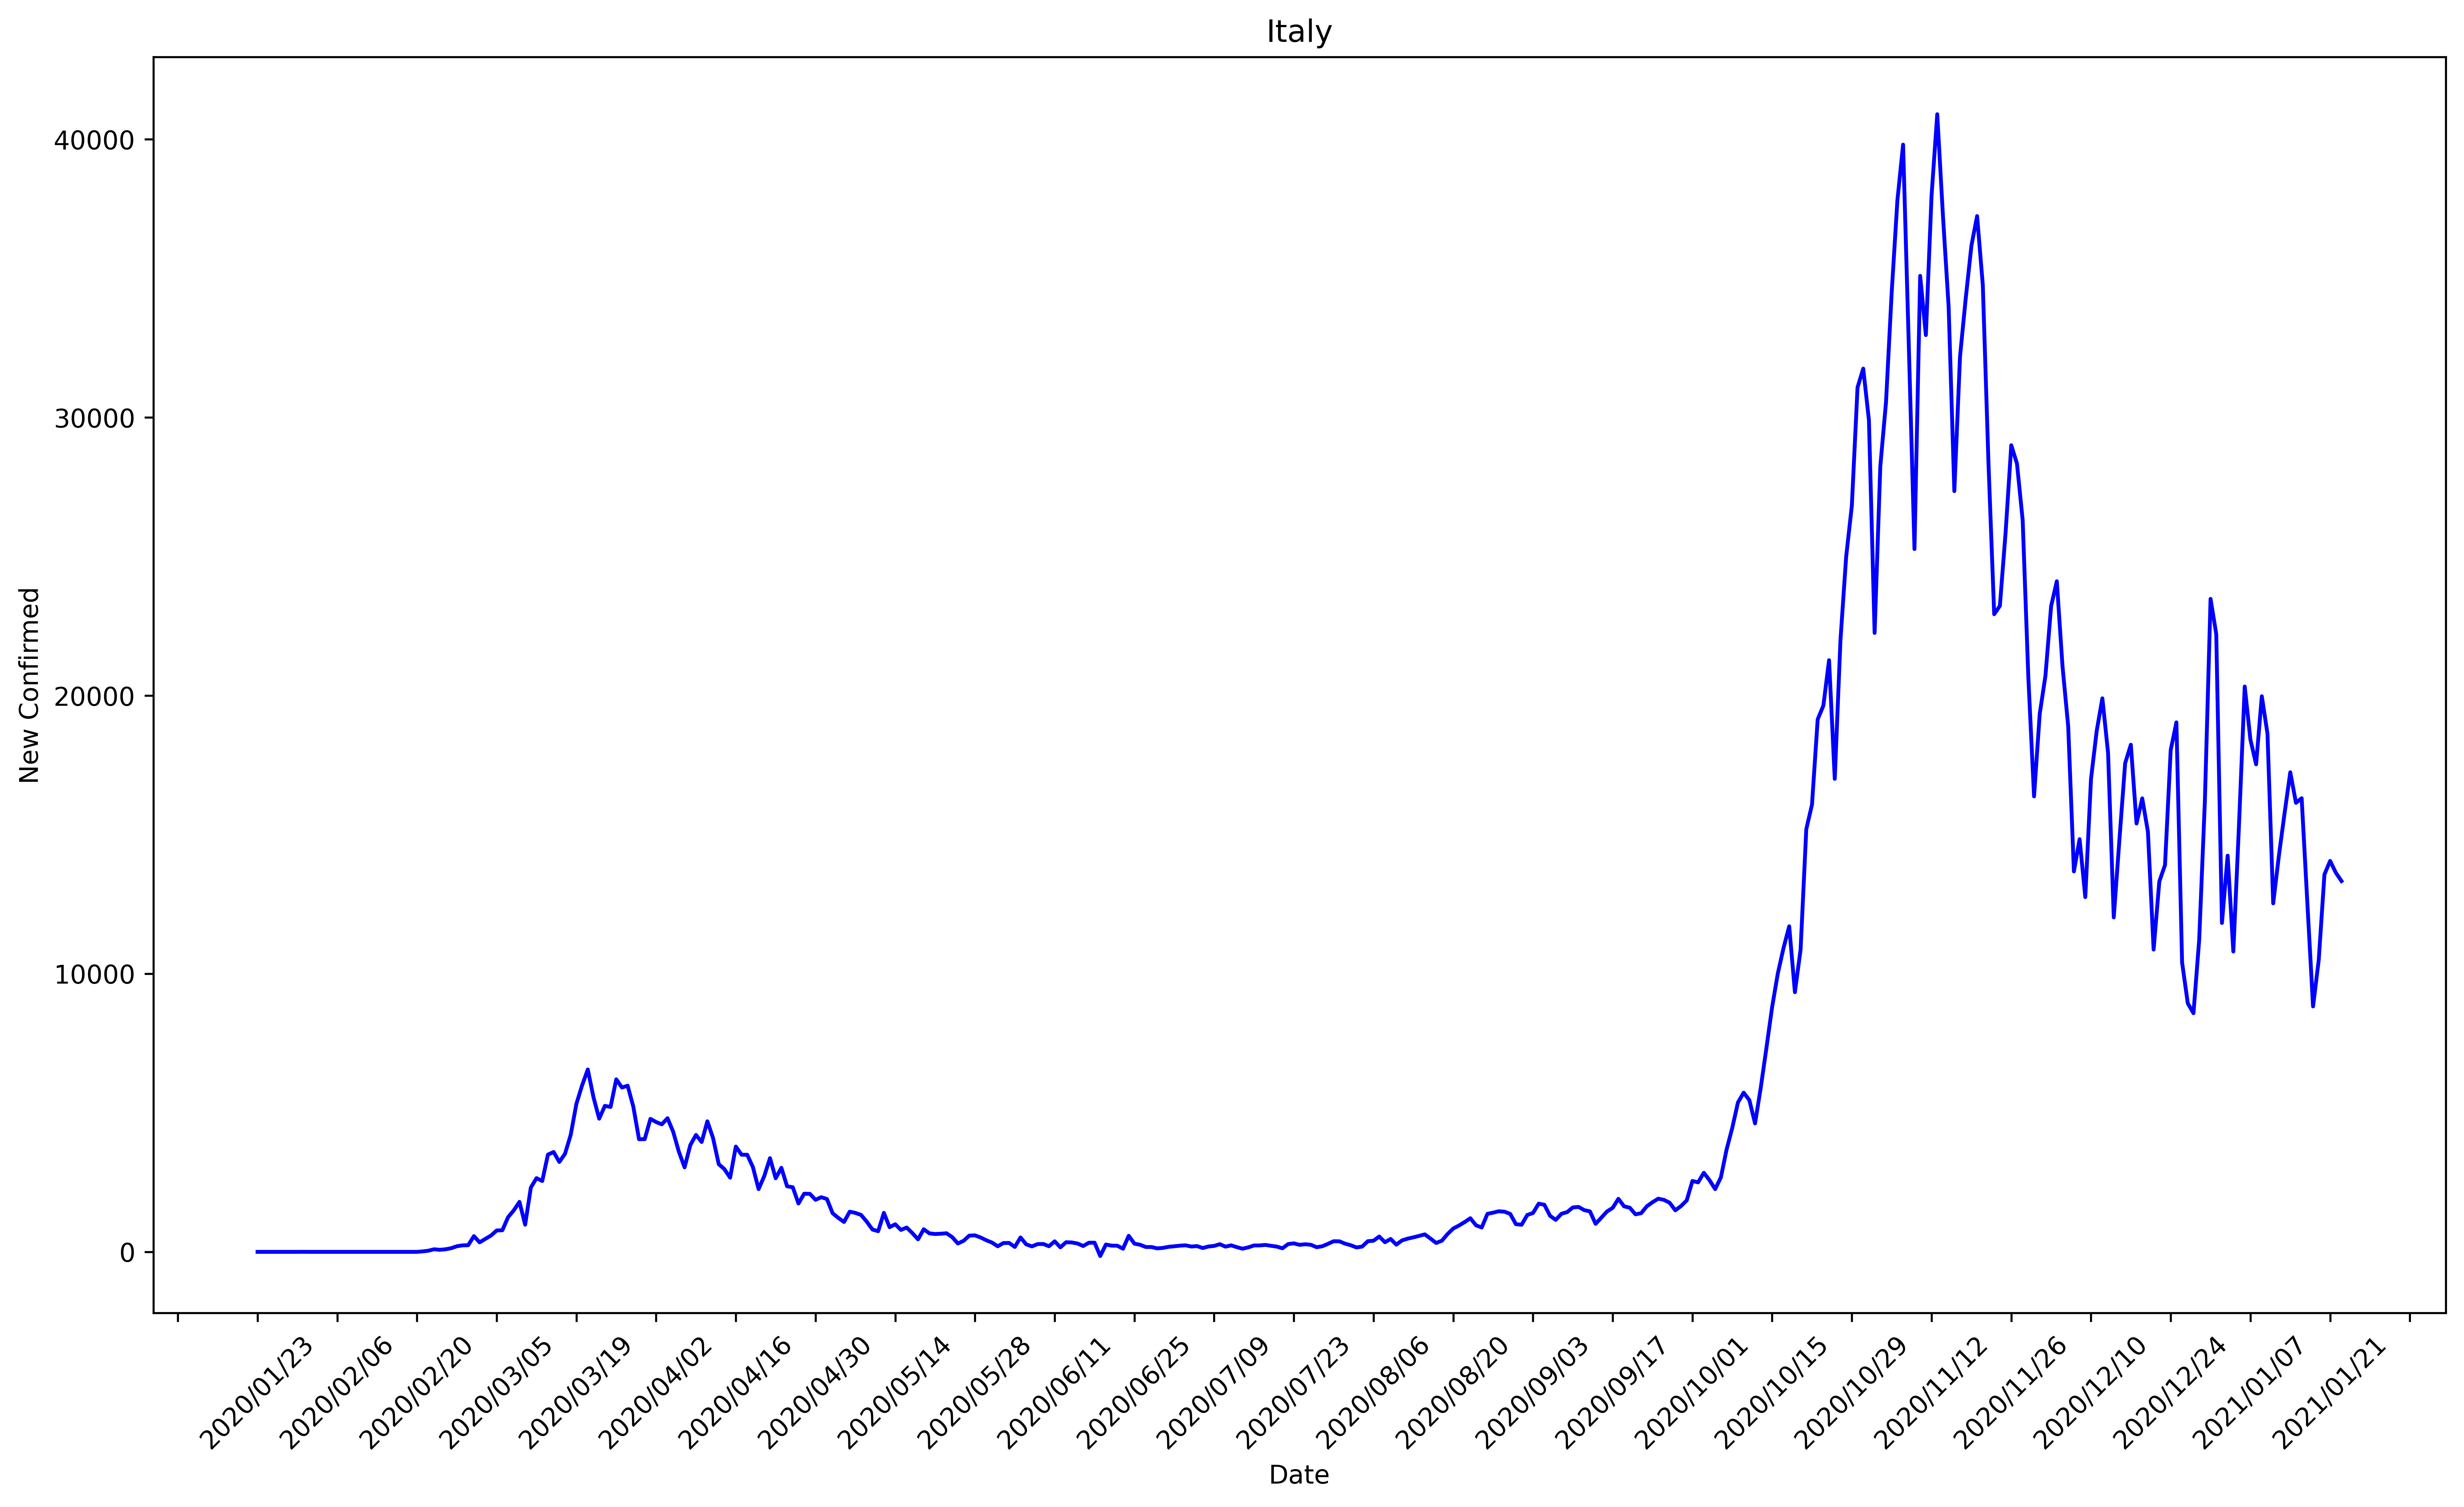

In [6]:
def new_confirmed_by_country(df, country_name):
    """

    :param df: dataframe
    :param country_name: nome del paese
    :return:
    """
    df_country = df[df['Country'] == country_name]
    fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi=600)
    ax.xaxis.set_major_locator(md.DayLocator(interval=14))
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("New Confirmed")
    plt.title(country_name)
    plt.plot([x for x in df_country['Date']],
             [y for y in df_country['New Confirmed']], 'b')
    plt.show()
new_confirmed_by_country(df, "Italy")

Si è notata una discordanza dei dati di alcuni paesi, tra cui la Francia. Il numero dei ***Confirmed***
in una certa data, a volte, risulta inferiore rispetto al giorno precedente. Questo fenomeno provoca la comparsa
di numeri negativi tra i ***New Confirmed***.

Considerando che i ***Confirmed*** sono i casi totali dall'inizio della pandemia, ci si aspetterebbe dei dati sempre
crescenti all'aumentare dei giorni.

Di seguito il grafico dei ***New Confirmed*** relativi alla Francia:

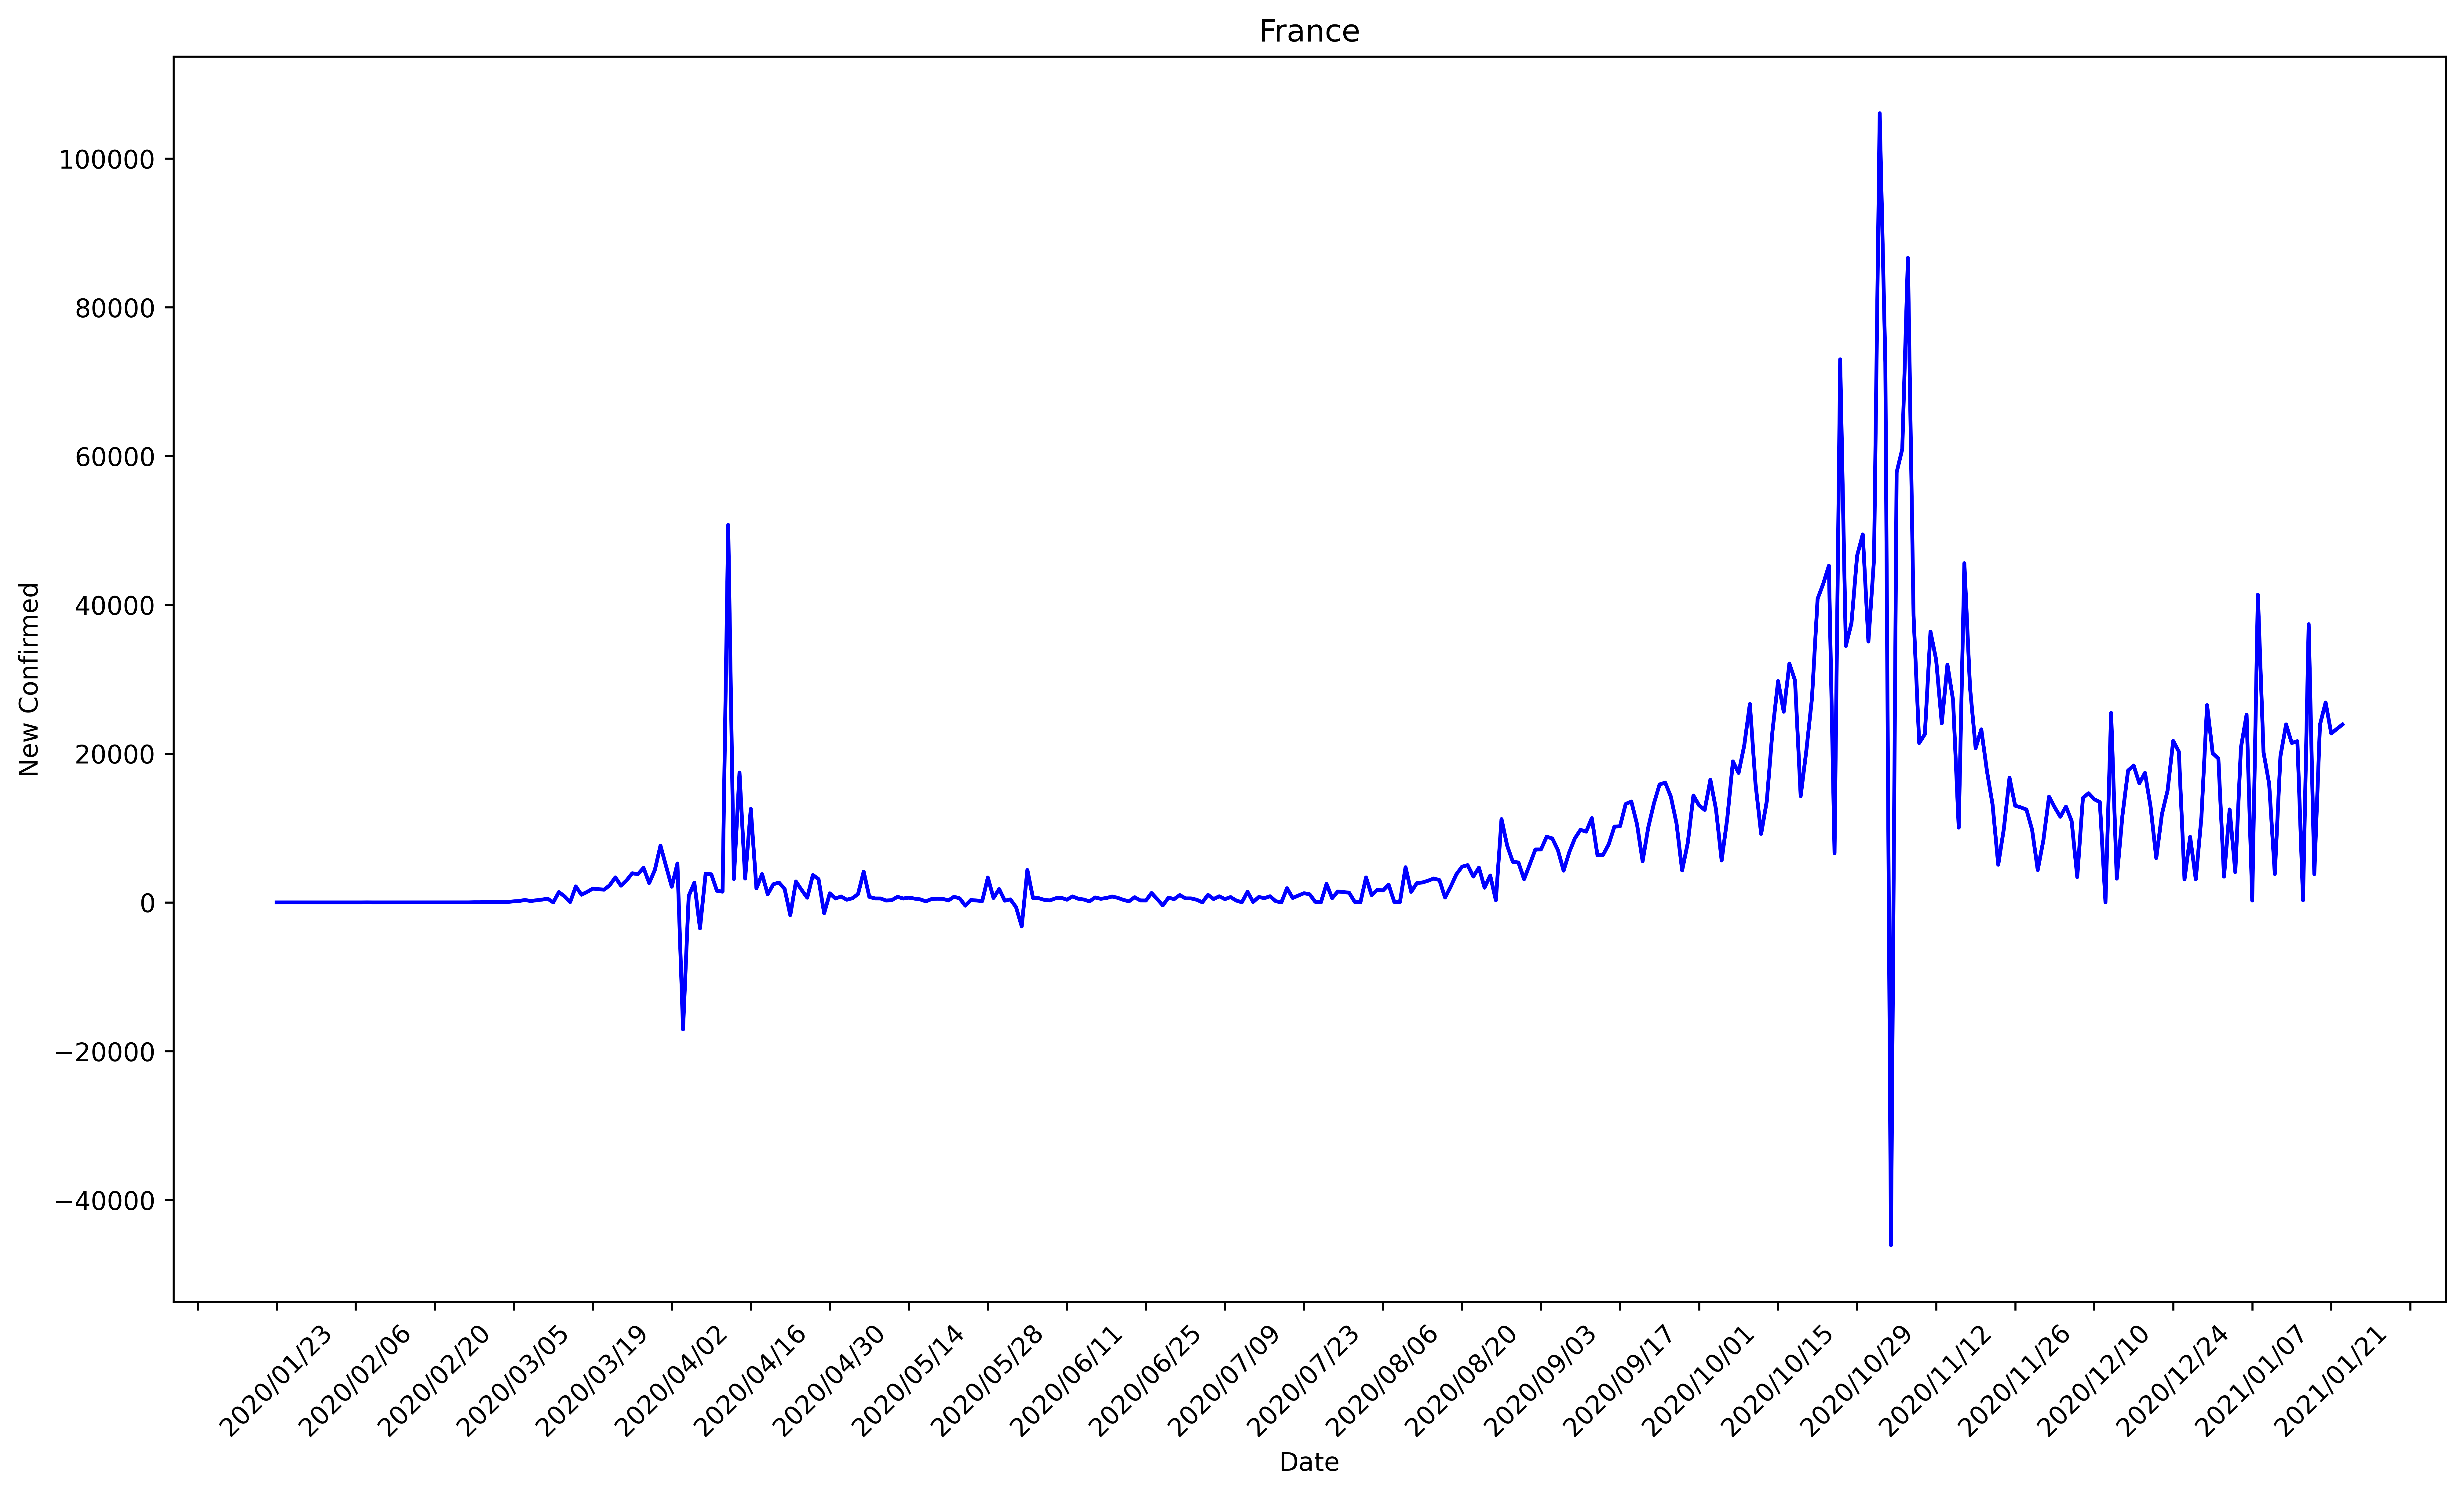

In [7]:
new_confirmed_by_country(df, "France")

La seguente funzione permette di graficare l'andamento dei ***"New Confirmed"***, di un daterminato paese, calcolati in
media mobile semplice a 7, 14, 21 e 28 giorni.

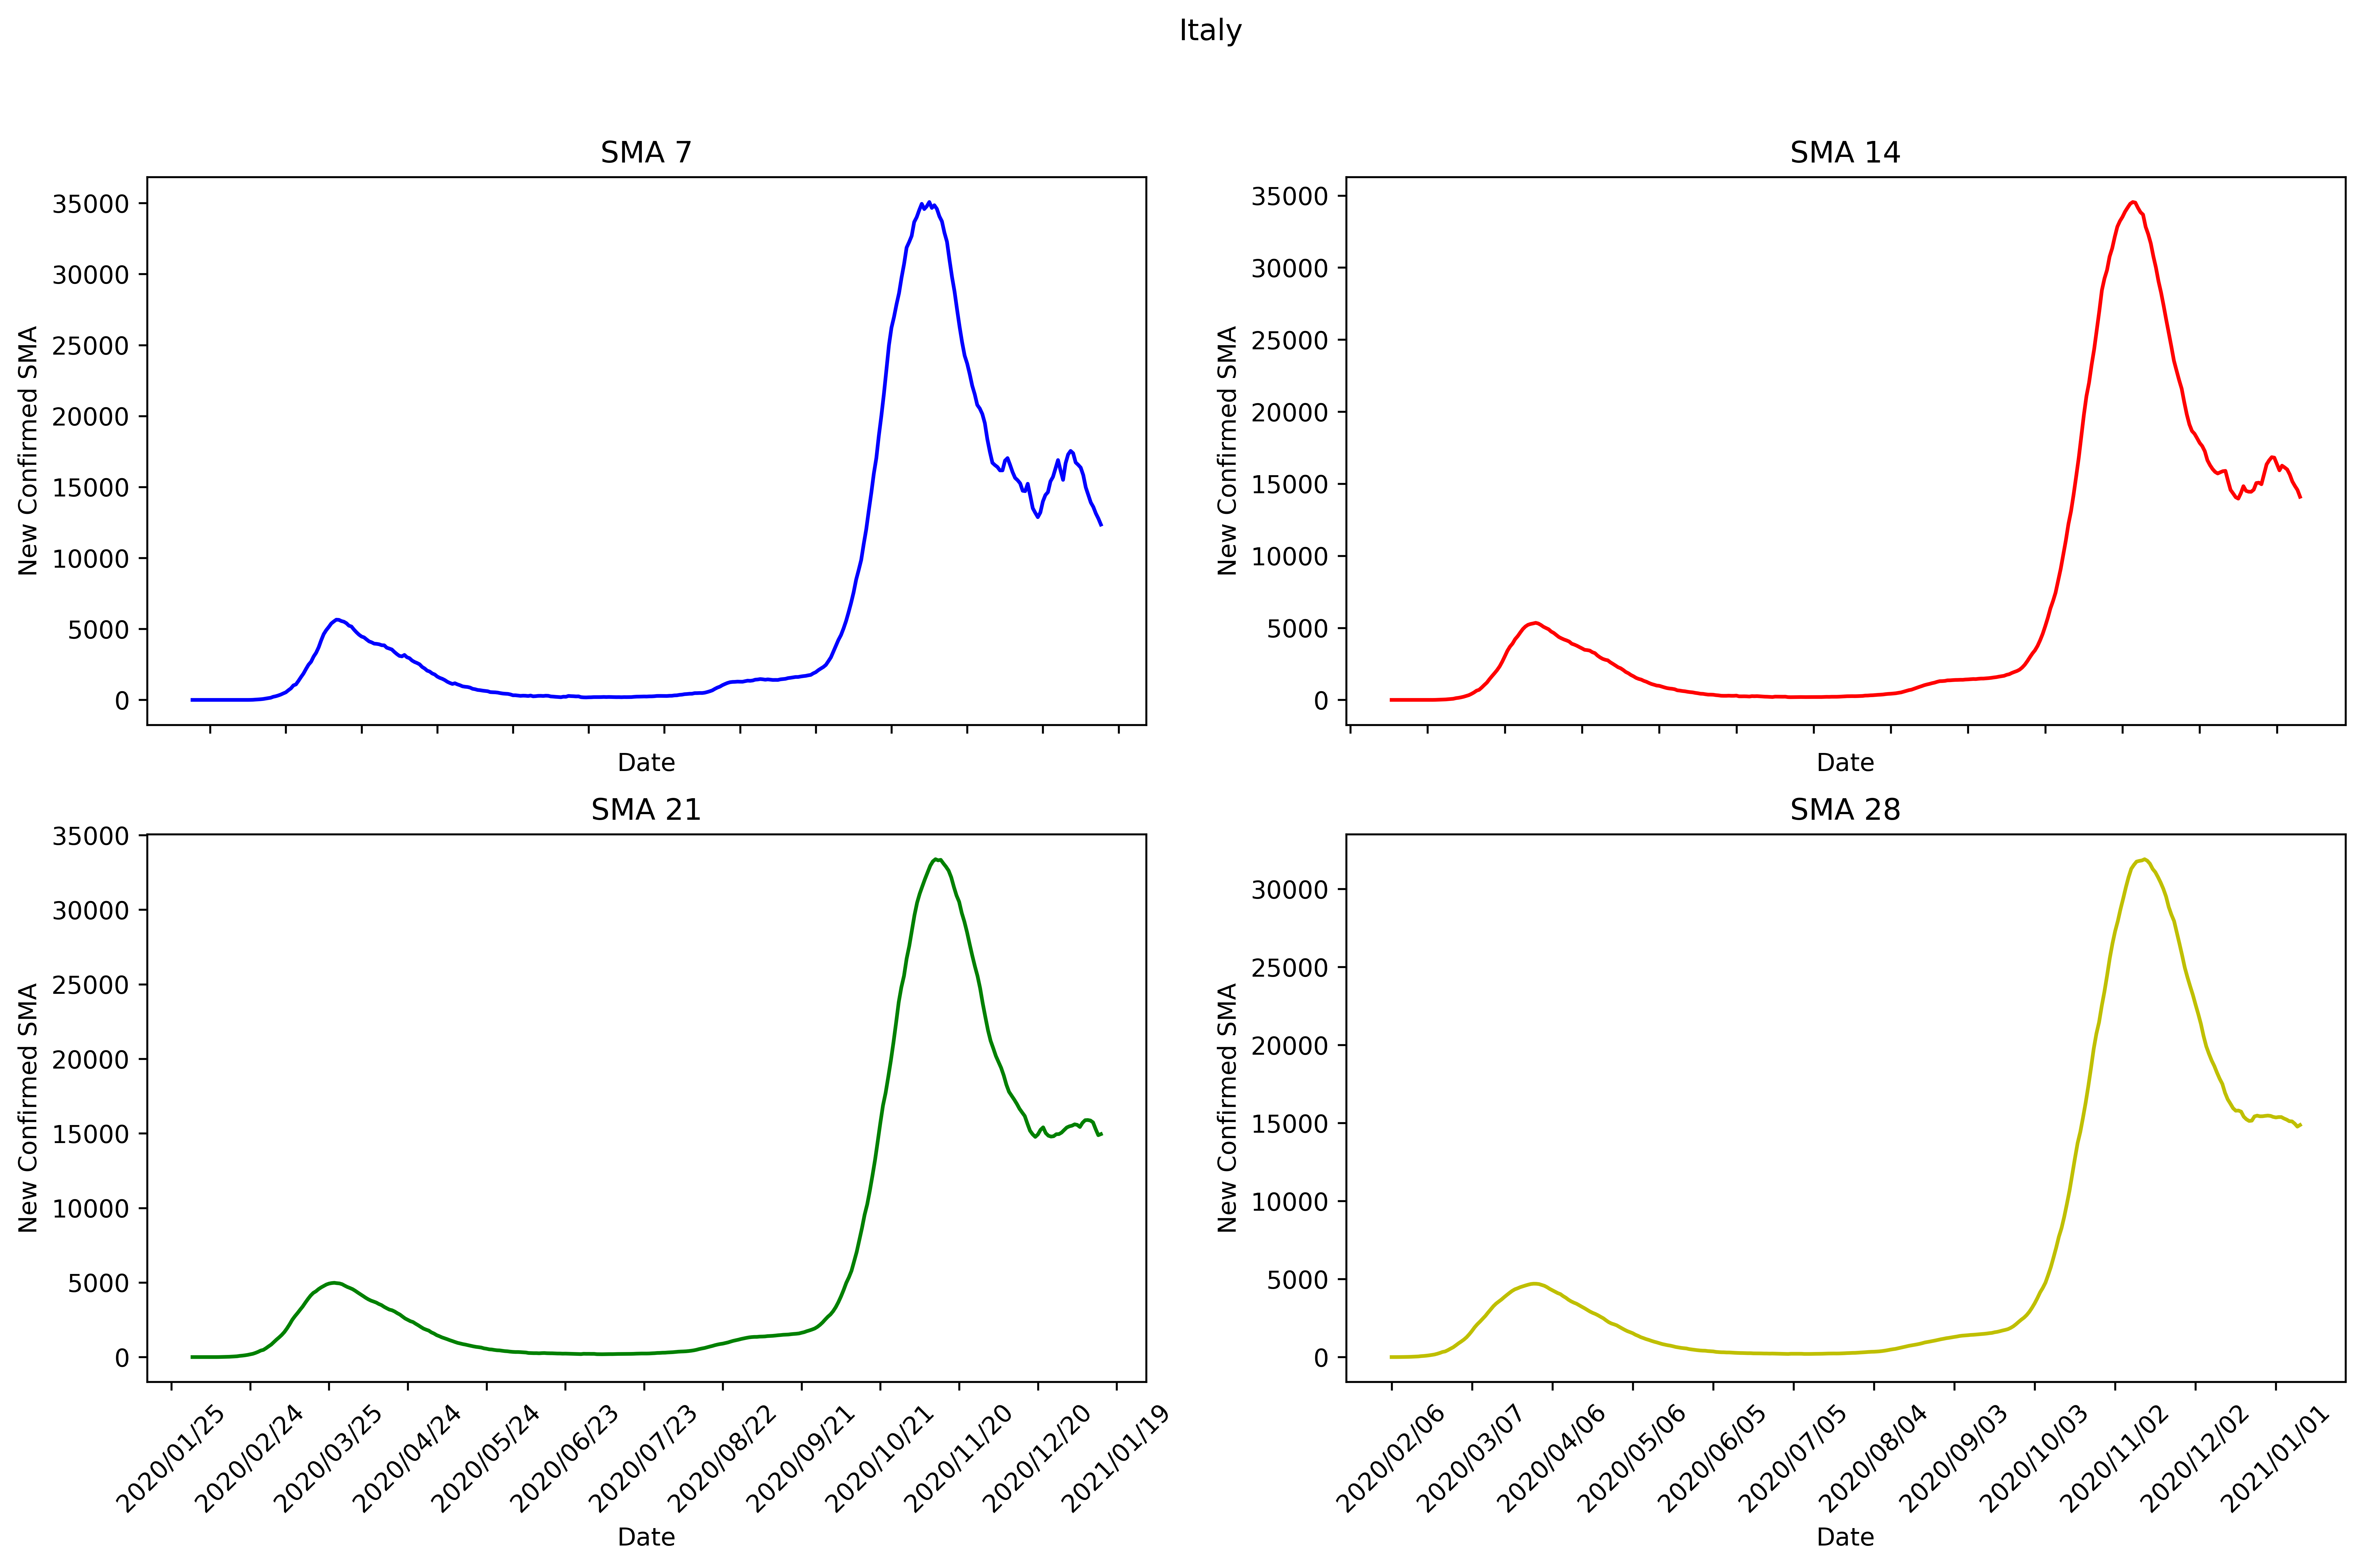

In [8]:
def simple_moving_average(df, country_name):
    """

    :param df: dataframe
    :param country_name: nome del paese
    :return:
    """
    df_country = df[df['Country'] == country_name]
    fig, axs = plt.subplots(2, 2, figsize=(16, 9), dpi=600) # permette di generare sottografici in un grafico
    plt.xticks(rotation=45) # rotazione dei ticks relativi alle date
    fig.suptitle(country_name)
    sma_7 = df_country['New Confirmed'].rolling(7, center=True).mean() # rolling().mean() permette il calcolo della
    sma_14 = df_country['New Confirmed'].rolling(14, center=True).mean() # media mobile
    sma_21 = df_country['New Confirmed'].rolling(21, center=True).mean()
    sma_28 = df_country['New Confirmed'].rolling(28, center=True).mean()
    plt.setp(axs[1 ,0].xaxis.get_majorticklabels(), rotation=45)
    plt.setp(axs[1 ,1].xaxis.get_majorticklabels(), rotation=45)
    axs[0 ,0].set_title("SMA 7")
    axs[0 ,0].xaxis.set_major_locator(md.DayLocator(interval=30))
    axs[0 ,0].plot([x for x in df_country['Date']],
             [y for y in sma_7], 'b')
    axs[0 ,1].set_title("SMA 14")
    axs[0 ,1].xaxis.set_major_locator(md.DayLocator(interval=30))
    axs[0 ,1].plot([x for x in df_country['Date']],
             [y for y in sma_14], 'r')
    axs[1 ,0].set_title("SMA 21")
    axs[1 ,0].xaxis.set_major_locator(md.DayLocator(interval=30))
    axs[1 ,0].plot([x for x in df_country['Date']],
             [y for y in sma_21], 'g')
    axs[1 ,1].set_title("SMA 28")
    axs[1 ,1].xaxis.set_major_locator(md.DayLocator(interval=30))
    axs[1 ,1].plot([x for x in df_country['Date']],
             [y for y in sma_28], 'y')
    axs[0, 1].set_xticklabels([])
    axs[0, 0].set_xticklabels([])
    for ax in axs.flat:
        ax.set(xlabel="Date", ylabel='New Confirmed SMA')
    plt.show()

simple_moving_average(df, "Italy")

La funzione ***european_country_comparison()*** permette di confrontare i grafici dell'andamento dei
***"New Confirmed"***, dei paesi Italia, Germania, Francia e Inghilterra, calcolati in media mobile semplice a 14 giorni;
questo per permettere una miglior visualizzazione dei risultati. Il grafico della media mobile permette di evidenziare il
trend della serie temporale, epurandolo dalle fluttuazioni giornaliere. È comunque possibile scegliere un valore
differente di giorni da applicare alla media mobile (parametro ***sma***), se settato a uno non viene applicata.

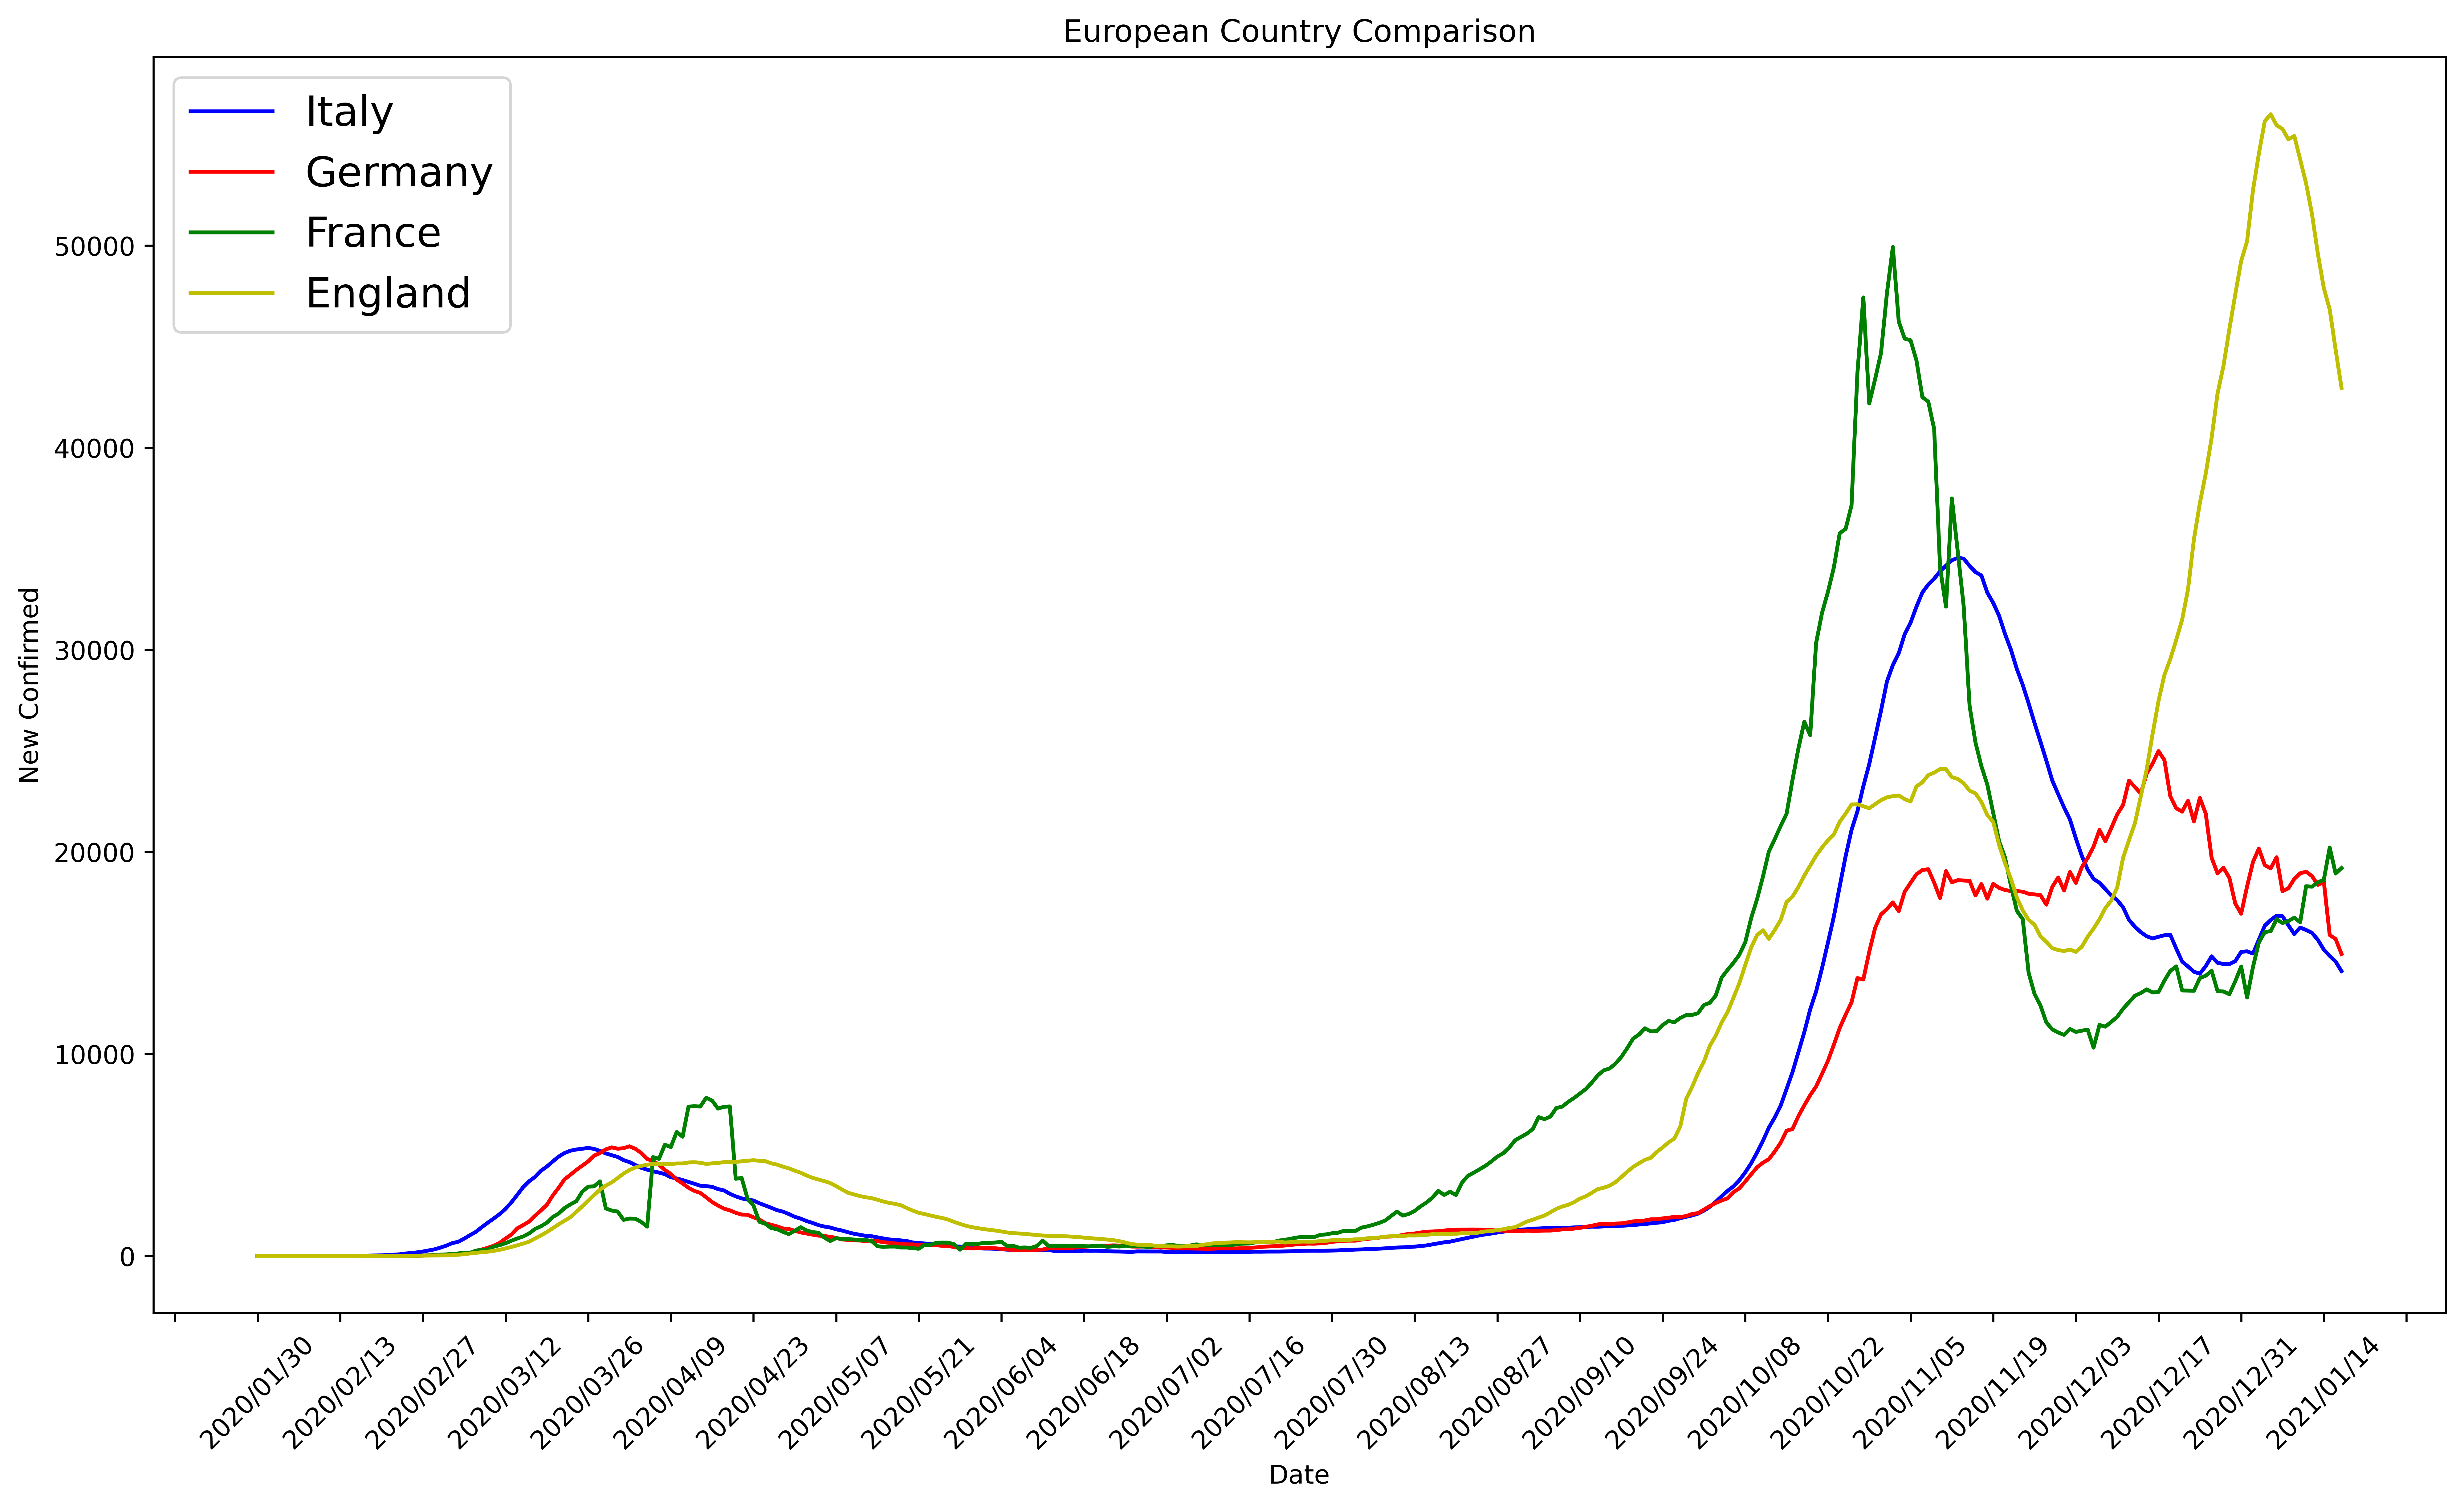

In [9]:
def european_country_comparison(df, sma):
    """

    :param df: dataframe
    :param sma: giorni media mobile
    :return:
    """
    italy = df[df['Country'] == "Italy"]
    germany = df[df['Country'] == "Germany"]
    france = df[df['Country'] == "France"]
    england = df[df['Country'] == "United Kingdom"]
    fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi=600)
    ax.xaxis.set_major_locator(md.DayLocator(interval=14))
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("New Confirmed")
    plt.title("European Country Comparison")
    plt.plot([x for x in italy['Date']],
             [y for y in italy['New Confirmed'].rolling(sma, center=True).mean()], 'b', label="Italy")
    plt.plot([x for x in germany['Date']],
             [y for y in germany['New Confirmed'].rolling(sma, center=True).mean()], 'r', label="Germany")
    plt.plot([x for x in france['Date']],
             [y for y in france['New Confirmed'].rolling(sma, center=True).mean()], 'g', label="France")
    plt.plot([x for x in england['Date']],
             [y for y in england['New Confirmed'].rolling(sma, center=True).mean()], 'y', label="England")
    plt.legend(prop={"size":16})
    plt.show()
european_country_comparison(df, 14)

La funzione seguente permette di graficare l'andamento dei ***"New Confirmed"*** mondiali, calcolati in
media mobile semplice a 30 giorni.

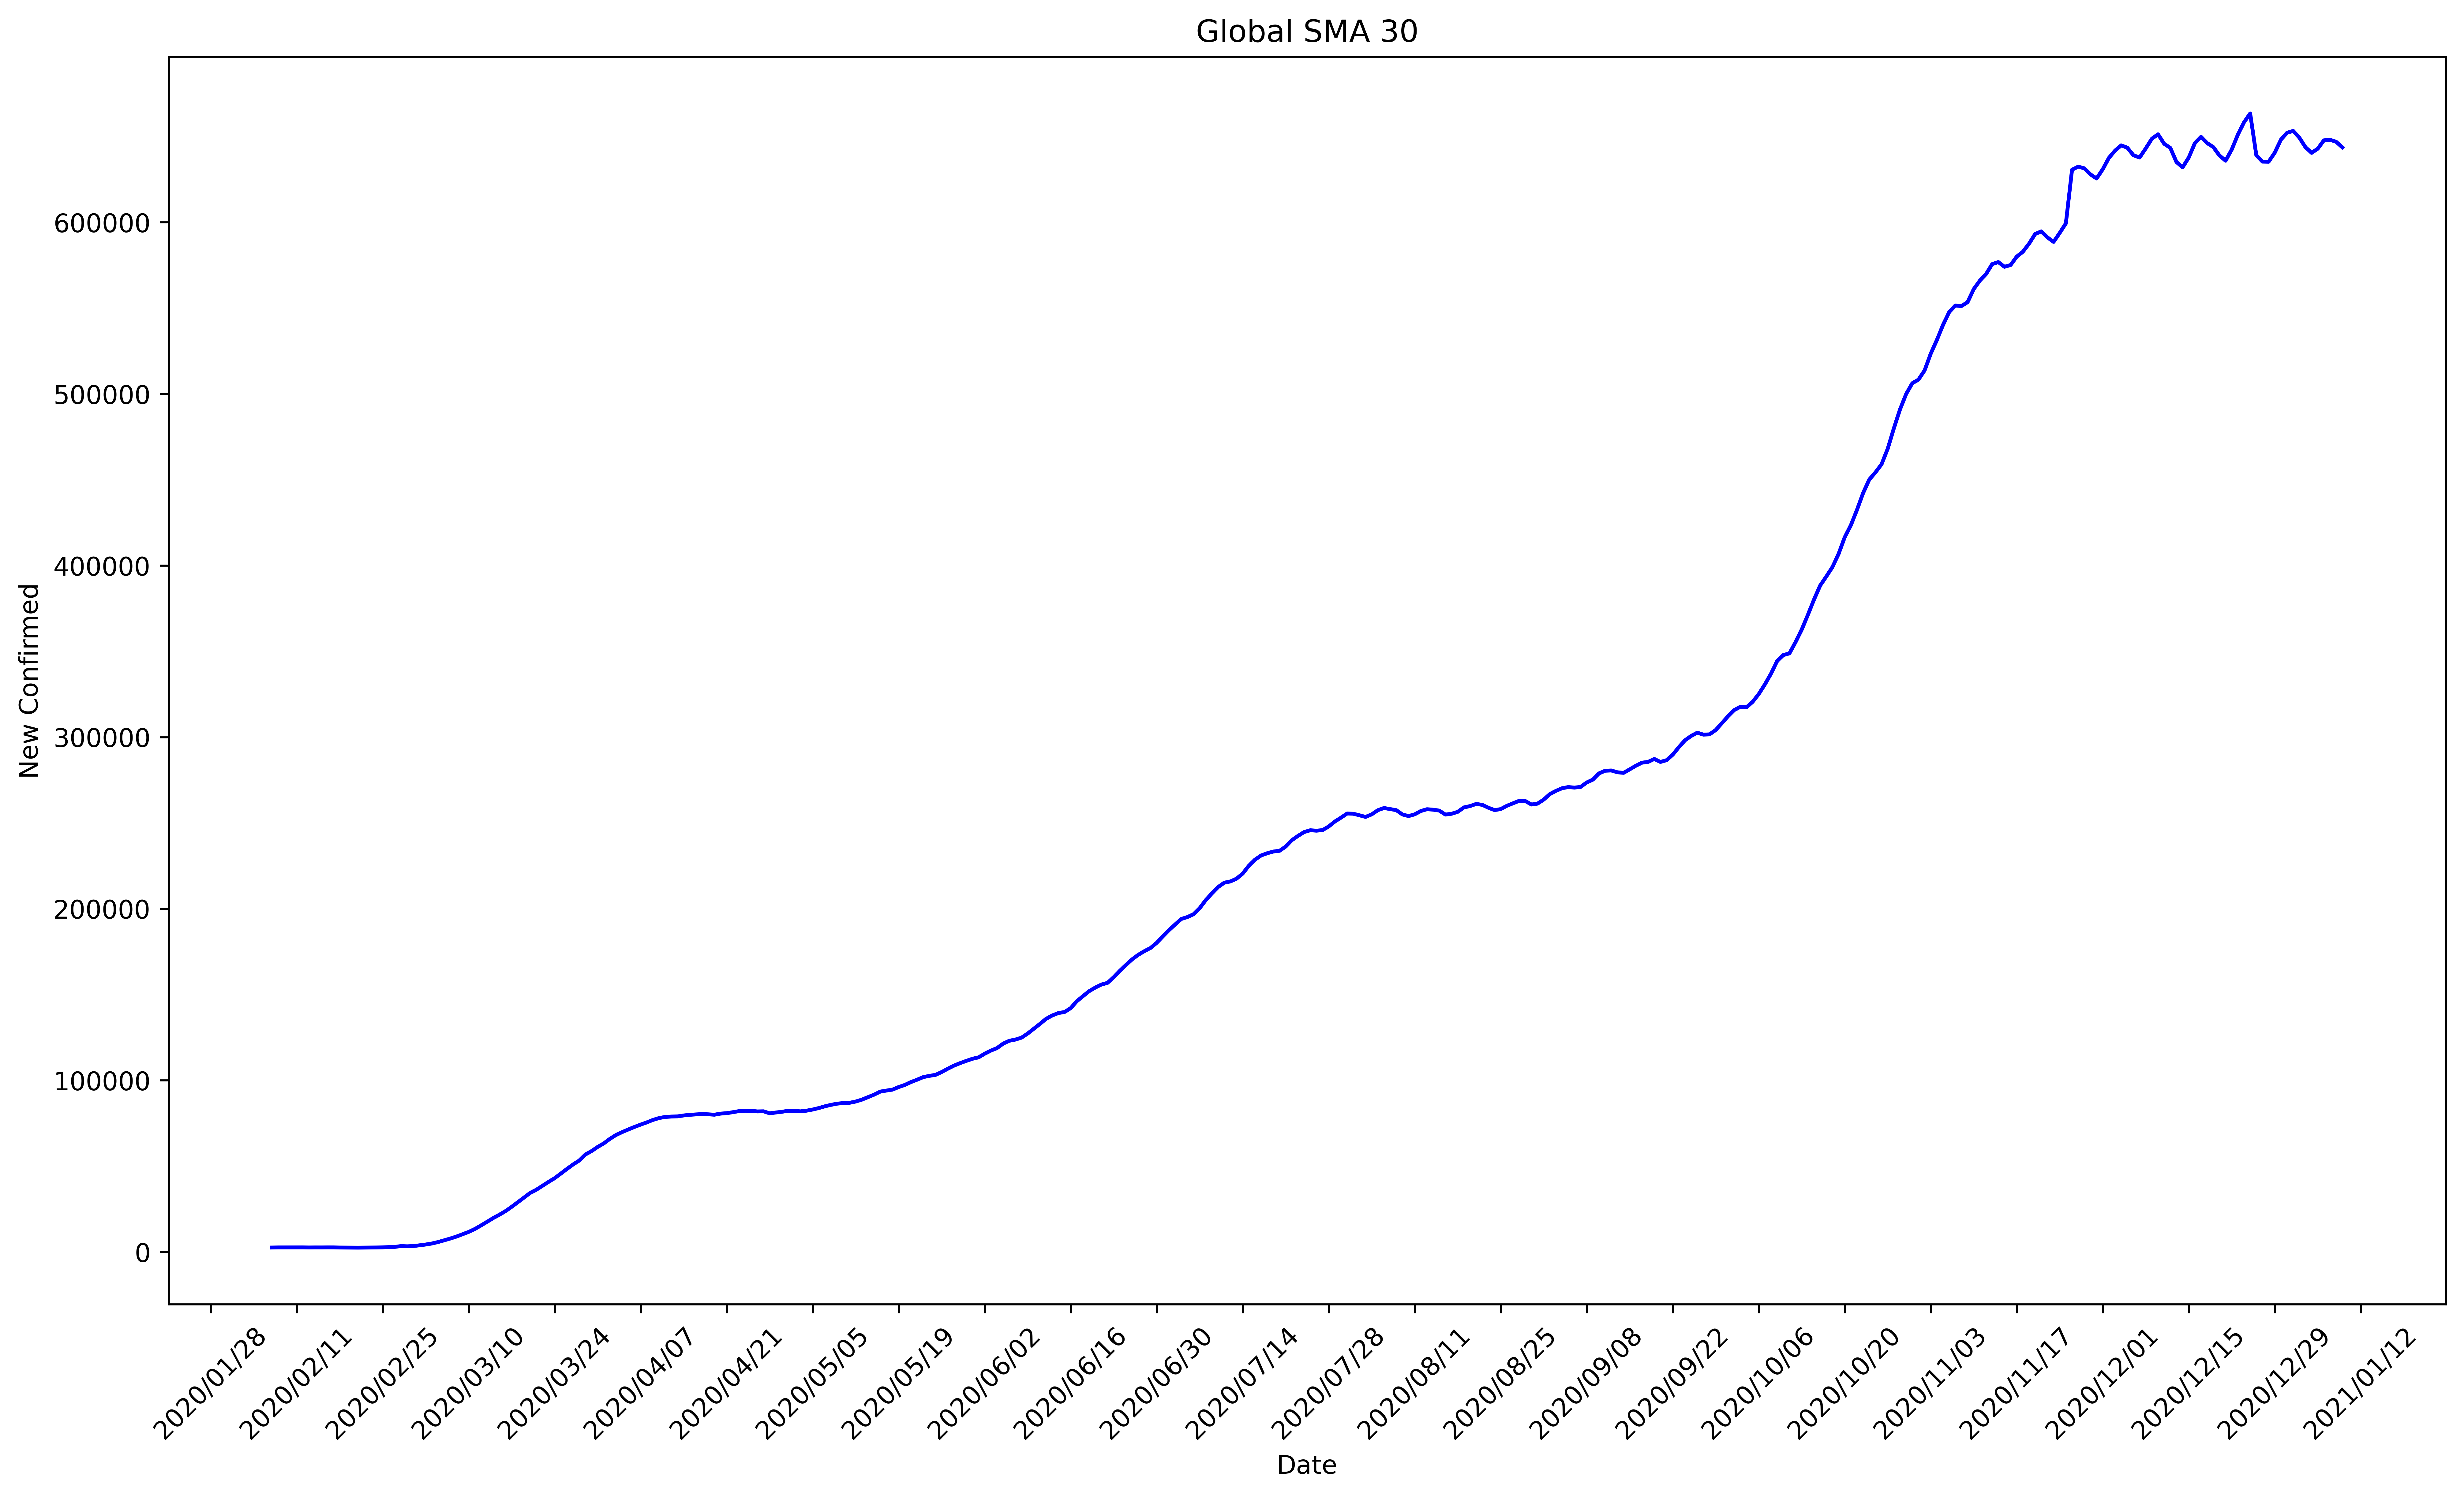

In [10]:
def global_simple_moving_average(df):
    """

    :param df: dataframe
    :return:
    """
    fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi=600)
    ax.xaxis.set_major_locator(md.DayLocator(interval=14))
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("New Confirmed")
    plt.title("Global SMA 30")
    plt.plot([x for x in df['Date']],
             [y for y in df['New Confirmed'].rolling(30, center=True).mean()], 'b')
global_simple_moving_average(df_world)

La funzione ***histogram_one_day()*** grafica l'andamento dei ***"New Confirmed"*** di ciascun paese, in una specifica
data.

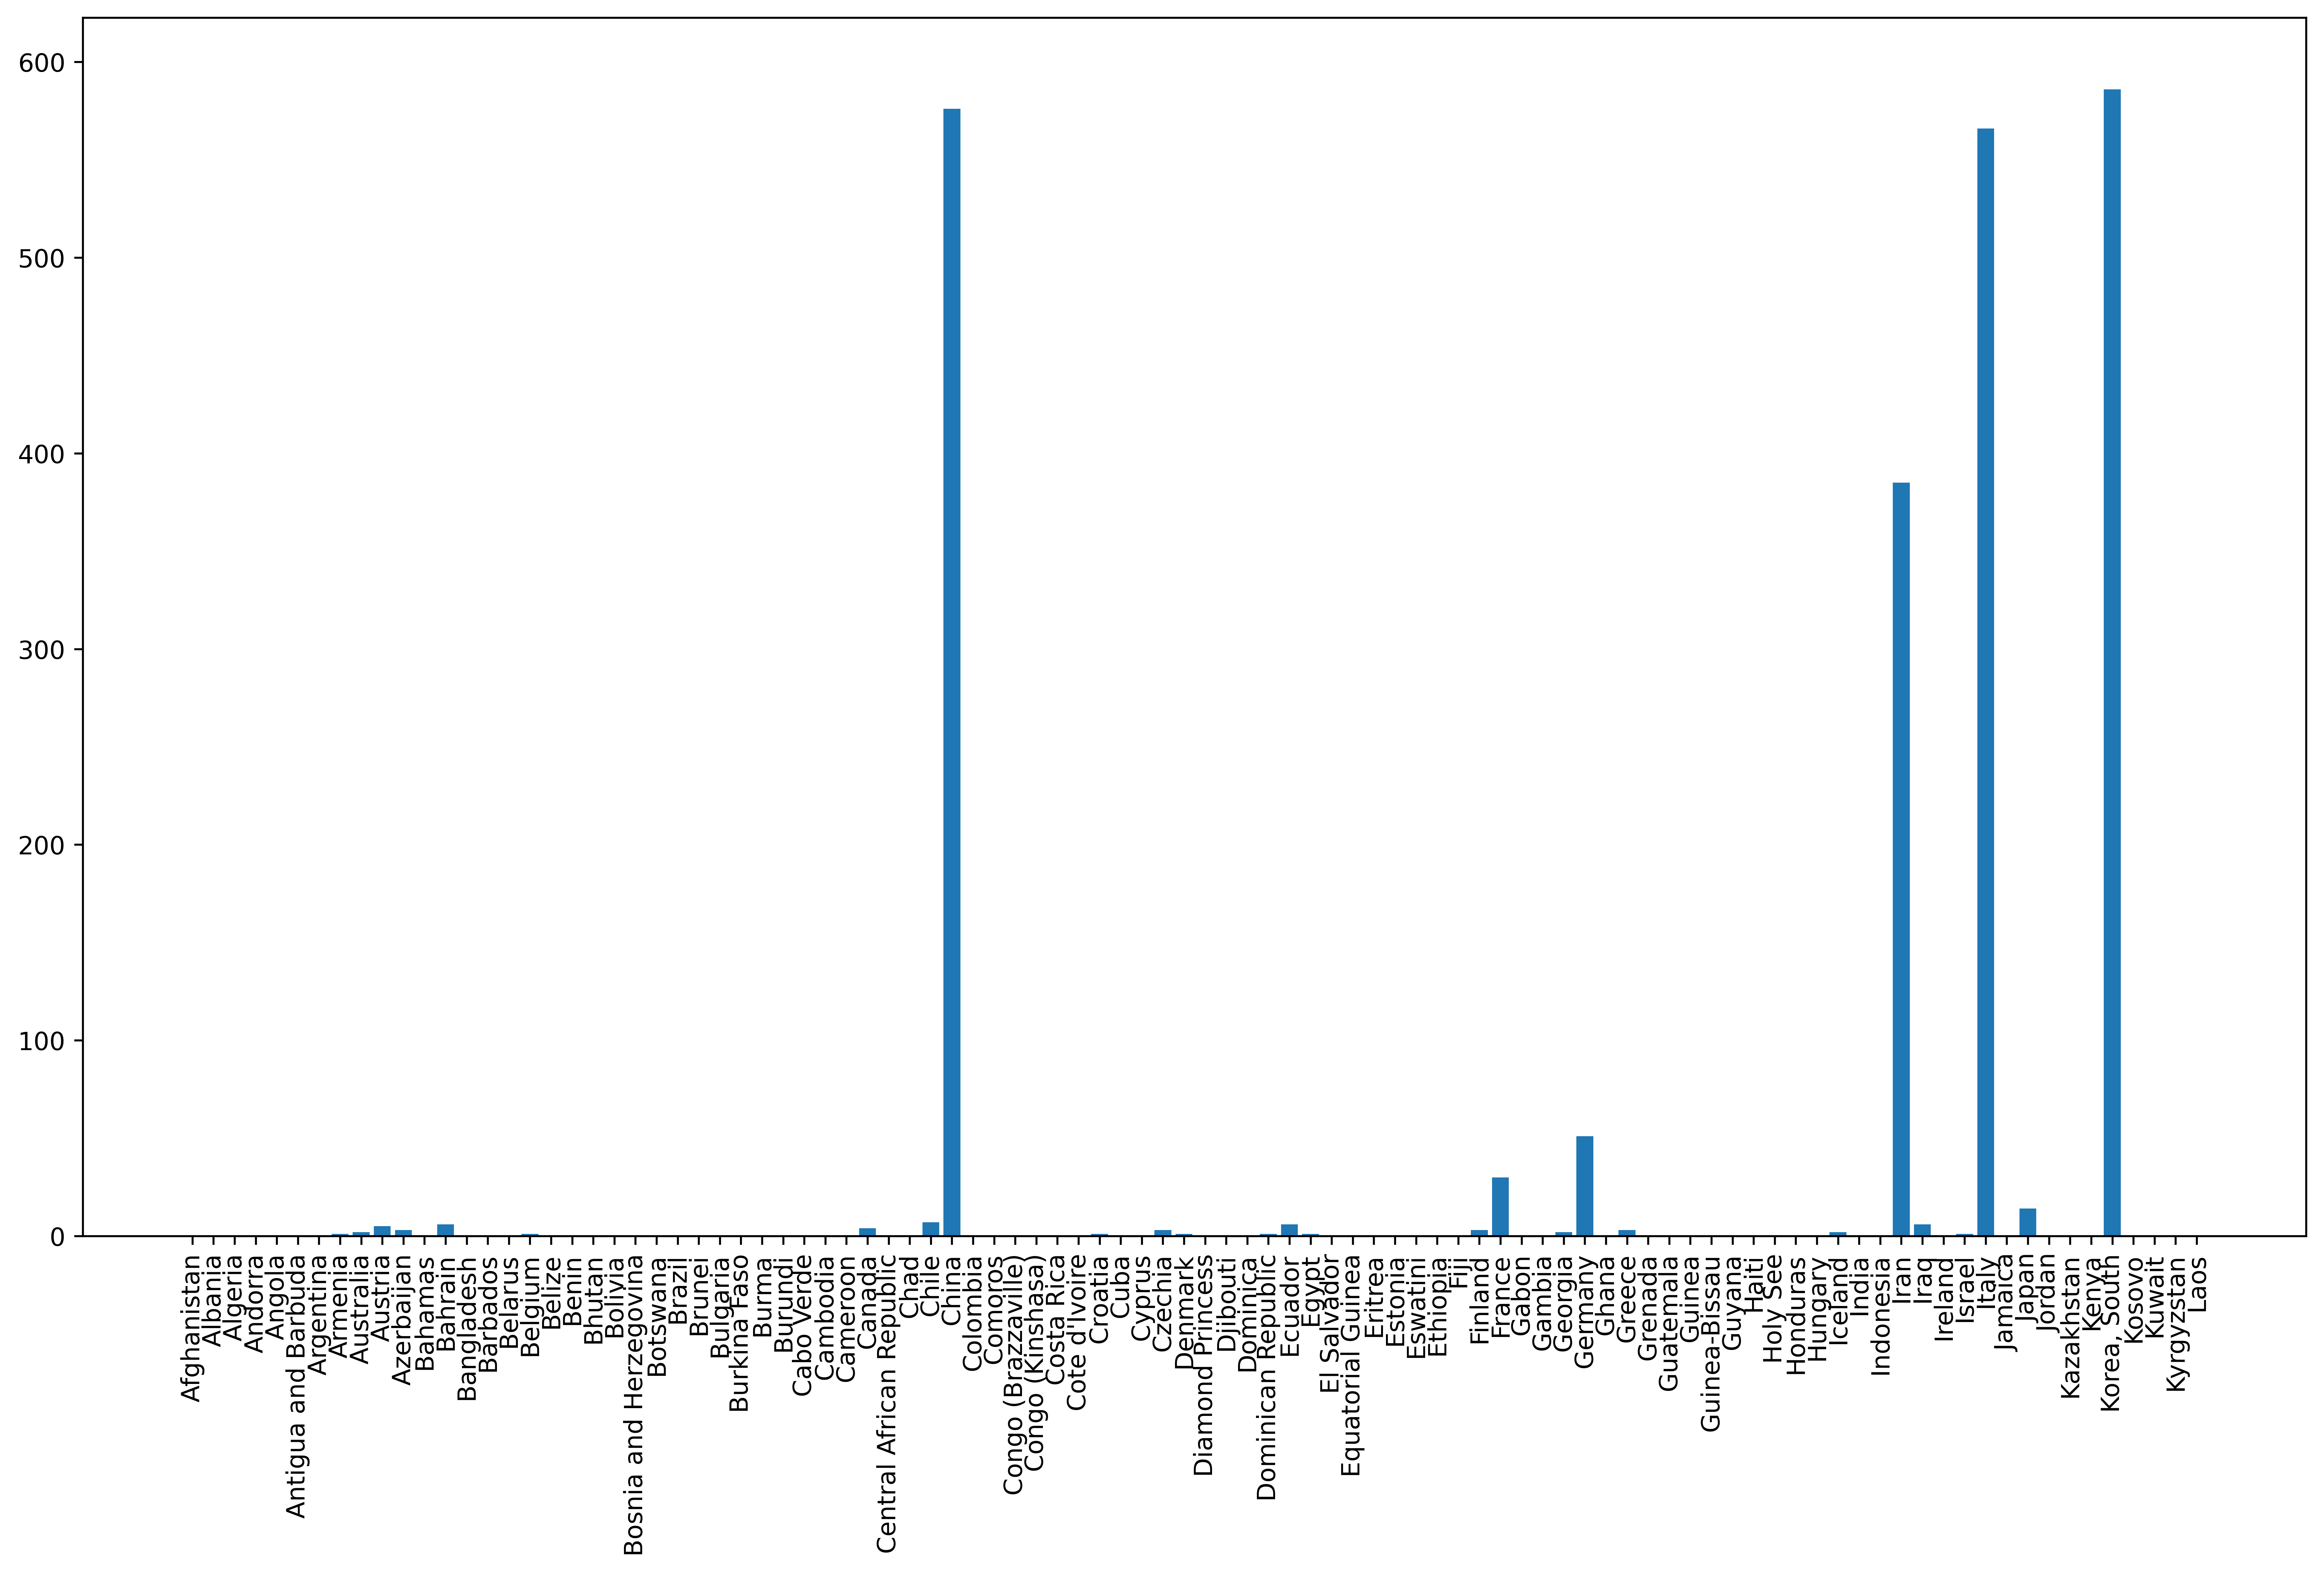

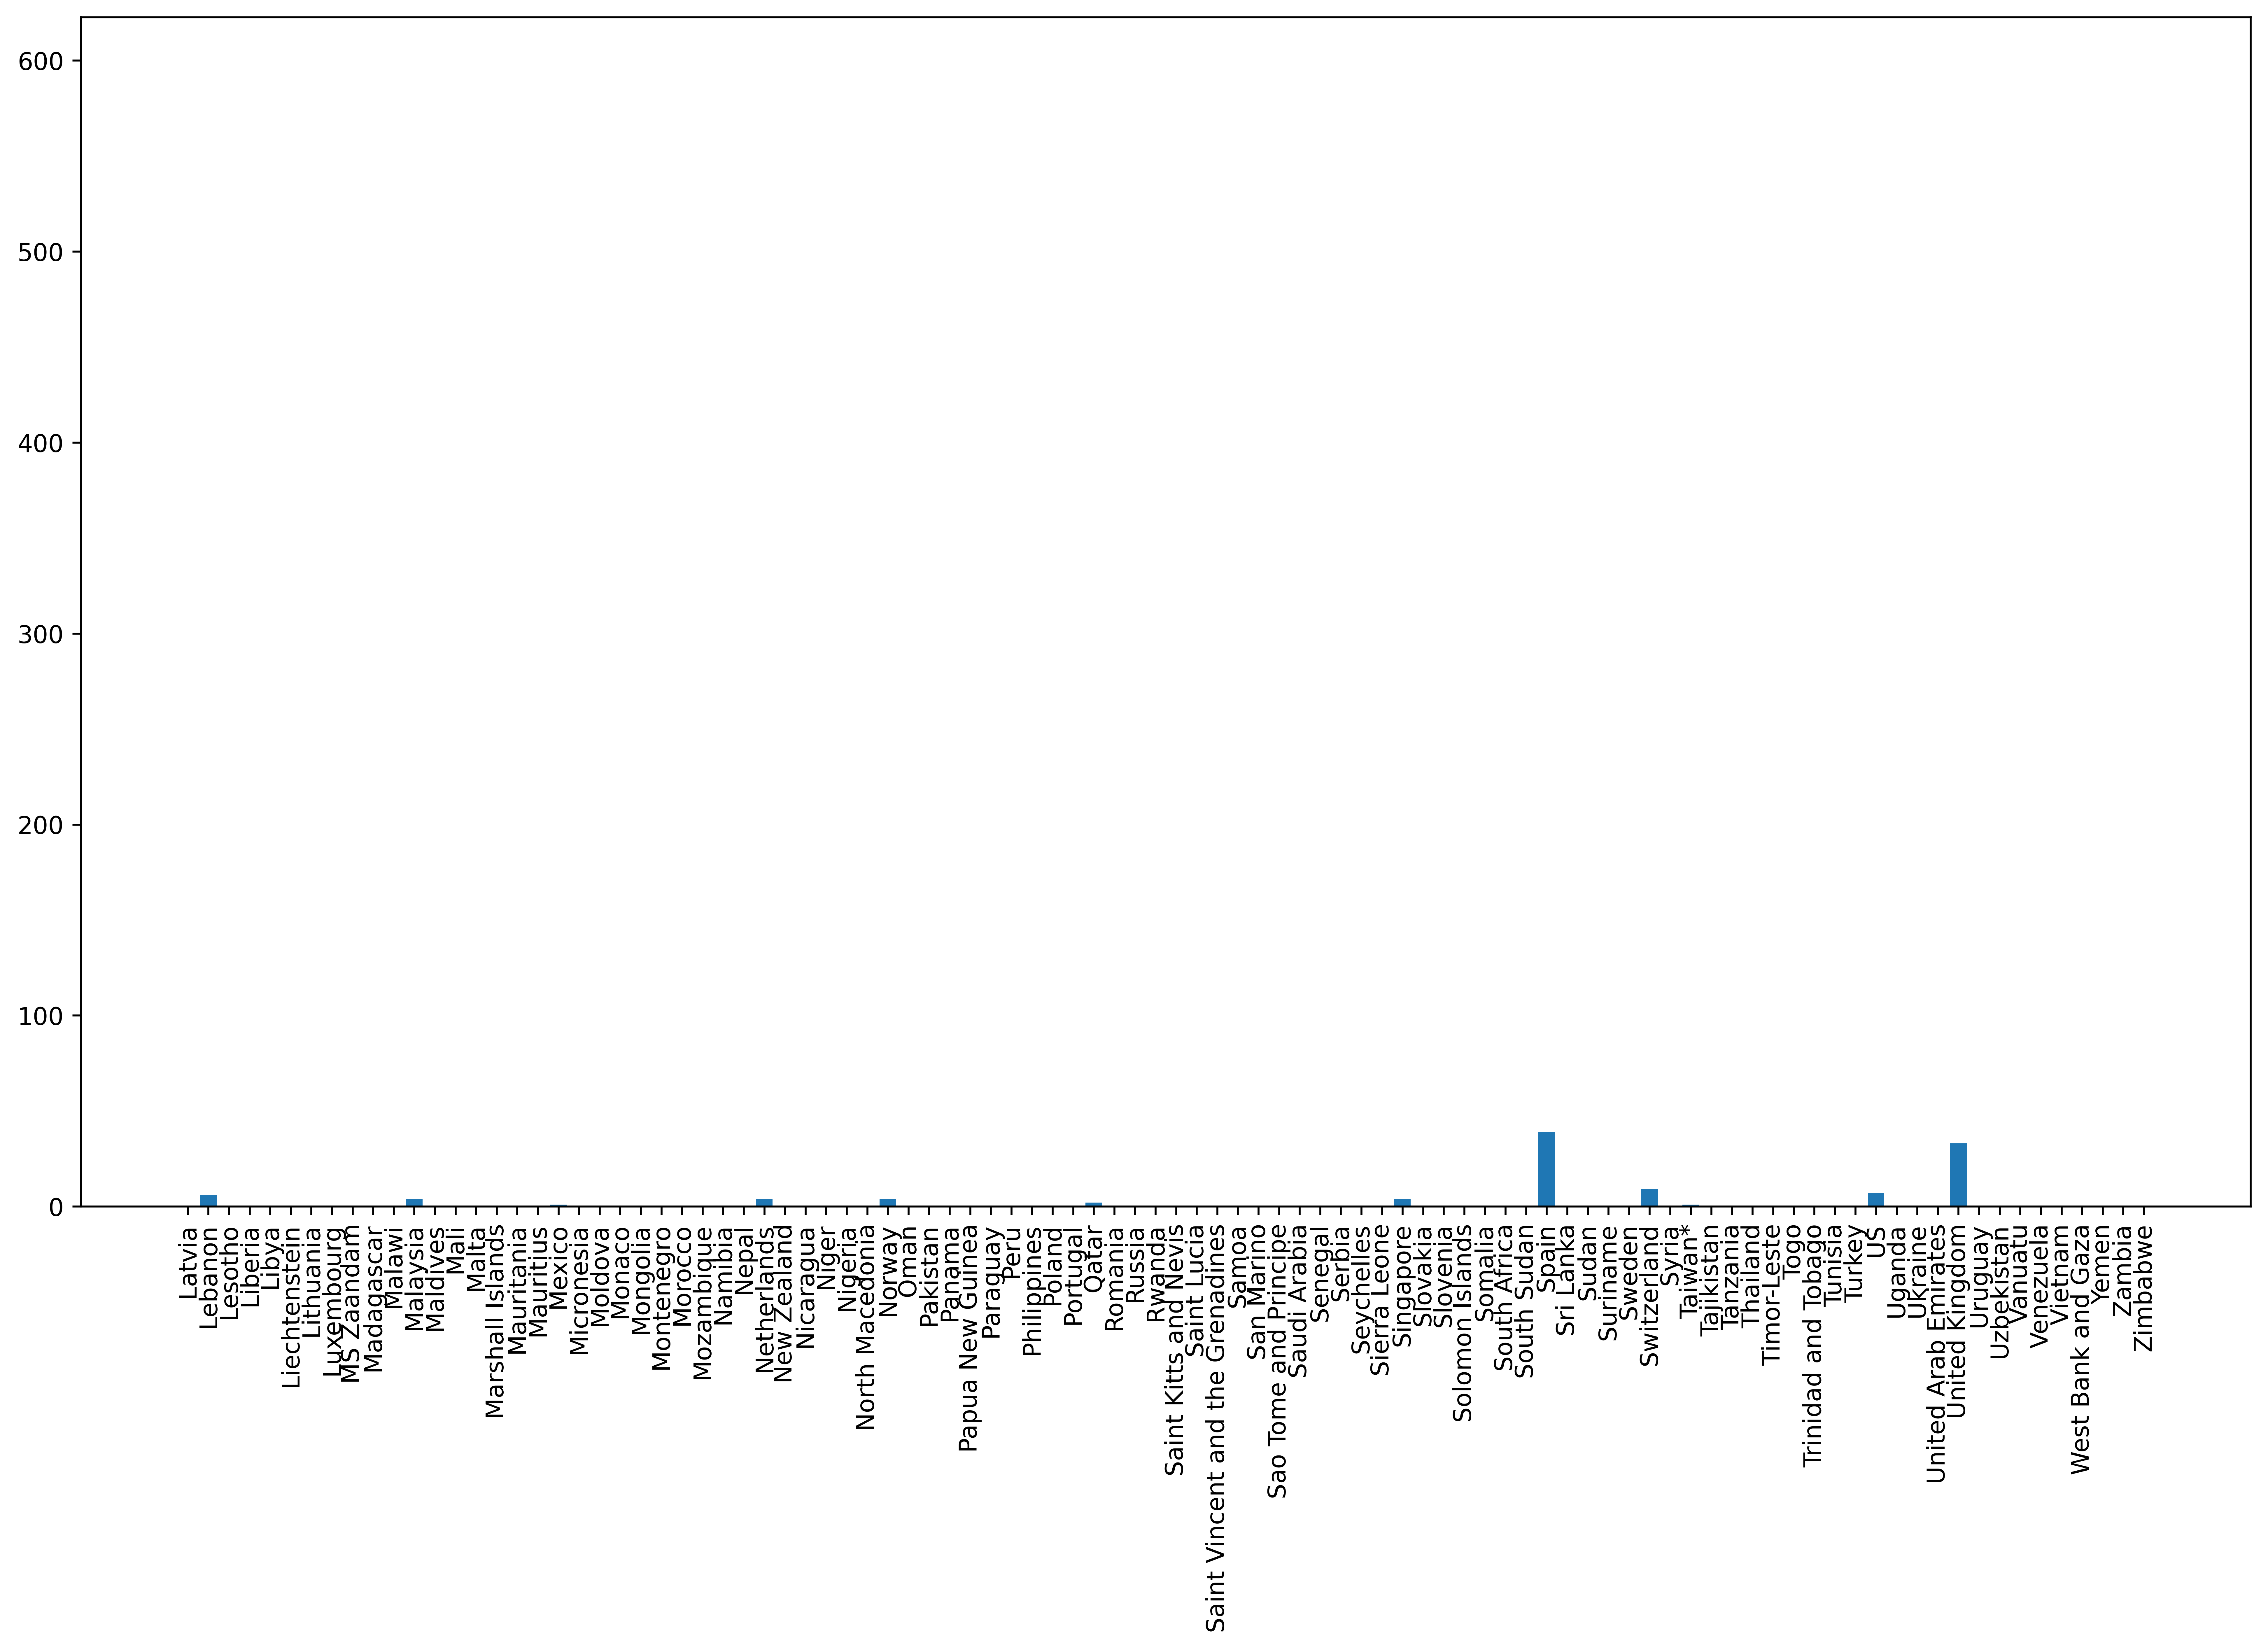

In [11]:
def histogram_one_day(df, date):
    """

    :param df: dataframe
    :param date: data yyyy/mm/dd
    :return:
    """
    df_pr = df[df["Date"] == date]
    max_nc = df_pr["New Confirmed"].max()
    plt.figure(figsize=(16, 9), dpi=600)
    plt.ylim(top=max_nc + max_nc/16)
    plt.xticks(rotation="vertical")
    plt.bar(df_pr["Country"][0:int(df_pr.shape[0]/2)], df_pr["New Confirmed"][0:int(df_pr.shape[0]/2)])
    plt.show()
    plt.figure(figsize=(16, 9), dpi=600)
    plt.ylim(top=max_nc + max_nc/16)
    plt.xticks(rotation="vertical")
    plt.bar(df_pr["Country"][int(df_pr.shape[0]/2):], df_pr["New Confirmed"][int(df_pr.shape[0]/2):])
    plt.show()
histogram_one_day(df, "2020/03/01")
